# Segmenting and Clustering Neighborhoods in Toronto
_This is a notebook for my analysis of the Neighborhoods in Toronto. All steps used are highlighted for reference purposes._

## Contents

[1. Import Libraries](#1.-Import-Libraries)

[2. Data Mining](#2.-Data-Mining)

[3. Data Cleaning](#3.-Data-Cleaning)    

[4. Retrieving Location Data](#4.-Retrieving-Location-Data)

[5. Visualizing Toronto Neighborhoods](#5.-Visualizing-Toronto-Neighborhoods)

[6. Exploring Selected Boroughs in Toronto](#6.-Exploring-Selected-Boroughs-in-Toronto)

[7. Analyzing Selected Boroughs in Toronto](#7.-Analyzing-Selected-Boroughs-in-Toronto)

[8. Clustering Neighborhoods using k-means](#8.-Clustering-Neighborhoods-using-k-means)

[9. Analyzing and Visualizing Clusters](#9.-Analyzing-and-Visualizing-Clusters)

[10. Conclusion](#10.-Conclusion)

## 1. Import Libraries
_All libraries that will be used for the analysis are imported in this section. This is preferred to enable notebook run smoothly and ensure you have all required packages for the analysis. Also, if you get an error while importing any module, check to ensure you have the package installed in your environment._

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 2. Data Mining
_Since a Wikipedia page exists that has all the information needed to explore the neighborhoods in Toronto. The data was scraped from the Wikipedia page and read into a Pandas dataframe. Since the data was already in a structured dataframe i.e. in tabular form, Pandas was the preferred option, otherwise, Beautiful soup package would have been used._

In [2]:
# Send the GET request
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
# Send the GET request
html = requests.get(url).content
tor_df = pd.read_html(html)
tor_df = tor_df[0]
tor_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
tor_df.shape

(180, 3)

In [4]:
borough_list = tor_df.index[tor_df['Borough'] == 'Not assigned']
neighborhood_list = tor_df.index[tor_df['Neighbourhood'] == 'Not assigned']
print('Prior to Cleaning, the Dataframe has: ')
print('{} Postal codes'.format(tor_df['Postal Code'].unique().shape[0]))
print('{} rows with Not assigned Borough'.format(borough_list.shape[0]))
print('{} rows with Not assigned Neighborhood'.format(neighborhood_list.shape[0]))

Prior to Cleaning, the Dataframe has: 
180 Postal codes
77 rows with Not assigned Borough
77 rows with Not assigned Neighborhood


## 3. Data Cleaning
_All the rows with "Not assigned" in the Boroughs column are dropped. In addition, the column titles are renamed as specified to PostalCode, Borough, and Neighborhood._

In [5]:
tor_df = tor_df.rename(columns={"Postal Code": "PostalCode", "Neighbourhood": "Neighborhood"})
tor_df = tor_df[tor_df.Borough !='Not assigned']
tor_df.reset_index(drop=True, inplace=True)
tor_df.head(12)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [6]:
tor_df.shape

(103, 3)

In [7]:
print('The final DataFrame shape is {}'.format(tor_df.shape))

The final DataFrame shape is (103, 3)


## 4. Retrieving Location Data
_All Longitude and Latitude values for the Postal codes in Toronto were downloaded from http://cocl.us/Geospatial_data. The Geopy library was used to get the latitude and longitude values of City of Toronto.  A user_agent needs to be defined to use an instance of Geocoder. In this case, I used "toronto_explorer" (Note: You can use any name you like)_

In [8]:
import geocoder # import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
tor_lat = location.latitude
tor_lon = location.longitude


print(tor_lat,tor_lon )

43.6534817 -79.3839347


In [9]:
lon_lat = pd.read_csv('http://cocl.us/Geospatial_data')

##### Display 1st 5 rows of data set

In [10]:
lon_lat.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##### Rename of "Postal Code" column to match that of the initial dataset 

In [11]:
lon_lat=lon_lat.rename(columns={'Postal Code':'PostalCode'})
lon_lat.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


##### Merge the two datasets with Neighborhoods with their respective Latitude and Longitude data

In [12]:
tor_df=tor_df.merge(lon_lat, on='PostalCode')

In [13]:
tor_df.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


## 5. Visualizing Toronto Neighborhoods
_In this section, the check the data set to explore the different neighborhoods we will be working with. Folium package is used to visualize the Neighborhoods on a Map based on their Longitude & Latitude Values._

In [14]:
# Check the various Boroughs in the Data set
print(tor_df.Borough.unique())
print('There are {} Boroughs'.format(tor_df['Borough'].unique().shape[0]))

['North York' 'Downtown Toronto' 'Etobicoke' 'Scarborough' 'East York'
 'York' 'East Toronto' 'West Toronto' 'Central Toronto' 'Mississauga']
There are 10 Boroughs


In [55]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[tor_lat, tor_lon], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(tor_df['Latitude'], tor_df['Longitude'], tor_df['Borough'], tor_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3296cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Map showing all Toronto Neighborhoods</b></h3>
             '''
map_toronto.get_root().html.add_child(folium.Element(title_html))

    
map_toronto

## 6. Exploring Selected Boroughs in Toronto
_In this section, we reduce the number of boroughs from the initial data set to only boroughs that have Toronto associated with their names i.e Downtown Toronto, East Toronto, West Toronto & Central Toronto. The Neighborhoods in these boroughs are further visualized on the map. 
Furthermore, the Foursquare API is used further explore these Neighborhoods based on the Latitude and Longitude data._

In [16]:
toronto_data = tor_df[tor_df['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [48]:
print('There are {} Boroughs'.format(toronto_data['Borough'].unique().shape[0]))
print('There are {} Neighborhoods with the same Postal Code'.format(toronto_data['Neighborhood'].unique().shape[0]))

There are 4 Boroughs
There are 39 Neighborhoods with the same Postal Code


In [51]:
# create map of Toronto using latitude and longitude values
map_toronto_sub = folium.Map(location=[tor_lat, tor_lon], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3296cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_sub)  

title_html = '''
             <h3 align="center" style="font-size:20px"><b>Map showing Selected Toronto Borughs & their Neighborhoods </b></h3>
             '''
map_toronto_sub.get_root().html.add_child(folium.Element(title_html))

map_toronto_sub

##### Using Foursauare API requires Client ID and Secret key which are entered below as well as the Version and Limit Value. Furthermore, a function "getNearbyVenues" is defined to return all Nearby venues within a 500-metre radius for each Neighborhood

In [19]:
CLIENT_ID = '3UHJFL2OXCQ0SDFMLYSC2SMMS0D4CAEXHVFGAJUTCSHKULBH' # Foursquare ID
CLIENT_SECRET = 'WPJPGVZ5L3WCI4FZ0WWTUHWLK52FHDZ1ILCNZRWXHCEC2ERW' # Foursquare Secret Key
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3UHJFL2OXCQ0SDFMLYSC2SMMS0D4CAEXHVFGAJUTCSHKULBH
CLIENT_SECRET:WPJPGVZ5L3WCI4FZ0WWTUHWLK52FHDZ1ILCNZRWXHCEC2ERW


In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

##### Return the Neighborhood venues into the dataframe

In [21]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [22]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [23]:
print (toronto_venues.shape)

(1624, 7)


A new dataframe called "toronto_venues" has 1624 venues for all the Neighborhoods

In [24]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [25]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


## 7. Analyzing Selected Boroughs in Toronto
_In this section, we analyze the different venues per Neighborhood. One hot encoding is used to transform categorical features as a one-hot numeric array so further analysis can be done on the dataset._

In [26]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
neigh = toronto_onehot['Neighborhood']
toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
toronto_onehot.insert(0, 'Neighborhood', neigh)
toronto_onehot.head()


,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [27]:
toronto_onehot.shape

(1624, 237)

Group the Neighborhoods and return the mean of the frequency of occurrence of each venue per neighborhood

In [28]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.0000,0.018182,0.036364,0.000000,0.000000,0.00,0.018182,0.018182,0.000000,0.036364,0.000000,0.000000,0.018182,0.0000,0.000000,0.0000,0.00,0.018182,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.018182,0.00,0.000000,0.0000,0.000000,0.036364,0.000000,0.000000,0.000000,0.000000,0.000000,0.036364,0.090909,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.018182,0.000000,0.018182,0.000000,0.000000,0.000000,0.018182,0.00

In [29]:
toronto_grouped.shape

(39, 237)

##### Use for loop to print out the Top 5 venues for each neighborhood

In [30]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.09
1    Cocktail Bar  0.04
2        Beer Bar  0.04
3  Farmers Market  0.04
4     Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3       Nightclub  0.09
4       Pet Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0  Gym / Fitness Center  0.06
1         Auto Workshop  0.06
2           Pizza Place  0.06
3            Comic Shop  0.06
4      Recording Studio  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0      Airport Lounge  0.12
1     Airport Service  0.12
2               Plane  0.06
3    Sculpture Garden  0.06
4  Airport Food Court  0.06


----Central Bay Street----
                venue  freq
0         Coffee Sho

Create a function 'return_most_common_venues' to return most common venues for each Neighborhood

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create new dataframe to display the top 10 venues for each neighborhood.

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Bakery,Farmers Market,Beer Bar,Restaurant,Cheese Shop,Bistro,Concert Hall
1,"Brockton, Parkdale Village, Exhibition Place",Café,Nightclub,Coffee Shop,Breakfast Spot,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
2,"Business reply mail Processing Centre, South C...",Pizza Place,Garden Center,Farmers Market,Butcher,Brewery,Burrito Place,Recording Studio,Garden,Auto Workshop,Fast Food Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Boutique,Plane,Airport,Airport Food Court,Airport Gate,Airport Terminal,Bar,Harbor / Marina
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Salad Place,Bubble Tea Shop,Department Store,Burger Joint,Japanese Restaurant,Thai Restaurant


## 8. Clustering Neighborhoods using k-means
_An unsupervised Machine Learning technique (k-means Clustering) is used in this section to group the similar Neighborhoods based on their Common venues attribute. However, to determine the optimum number of clusters, the elbow method is used. A special function "KneeLocator" is called from the Kneed package to return the optimum number of clusters because it is difficult to determine the point of inflection on the Elbow plot._

In [33]:
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

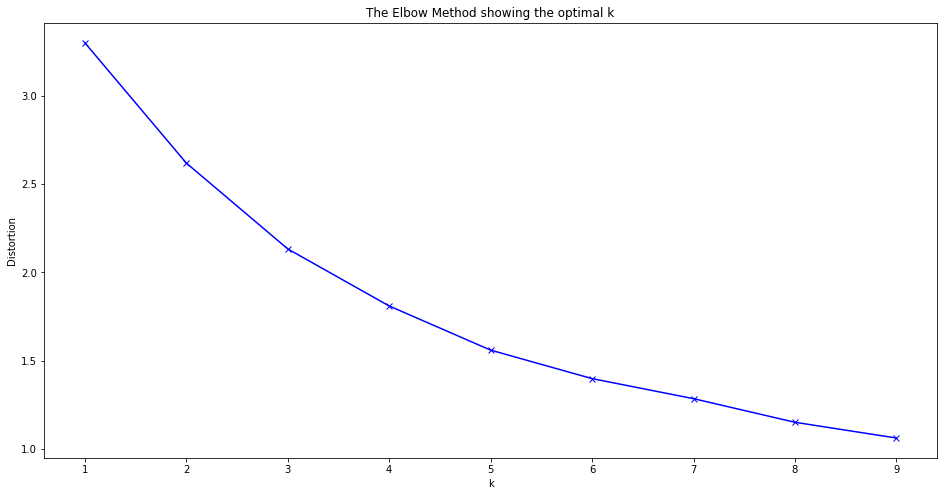

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [35]:
from kneed import KneeLocator
kl = KneeLocator(range(1, 10), distortions, curve="convex", direction="decreasing")
print('The optimum number of clusters is: ' + str(kl.elbow))


The optimum number of clusters is: 4


Using K-means Clustering to group Neighborhoods with similar attributes

In [36]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2])

Merge previous dataframe with Latitude and Longitude values with CLuster Labels

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_merged data with Longitude and Latitude values with neighbourhood_venues_sorted data into one data frame
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the frist 5 columns

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Bakery,Pub,Breakfast Spot,Café,Theater,Shoe Store,Brewery,Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Diner,Restaurant,Portuguese Restaurant,Park,Music Venue,Mexican Restaurant,Italian Restaurant,Hobby Shop
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Japanese Restaurant,Cosmetics Shop,Lingerie Store,Hotel,Bookstore,Pizza Place
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2,Coffee Shop,Café,Cocktail Bar,Restaurant,Beer Bar,Gastropub,American Restaurant,Farmers Market,Hotel,Japanese Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Pub,Trail,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Donut Shop


## 9. Analyzing and Visualizing Clusters
_In this section, the aim is to explore why the Neighborhoods were grouped under a particular cluster. The "toronto-merged" data frame is sliced to show Cluster labels and their 1st Most common venues. A group bar plot is used to show the various clusters and their most popular venues._

In [38]:
toronto_merged2 = toronto_merged.drop(columns=['PostalCode','Borough','Neighborhood','Latitude','Longitude'])
plot=toronto_merged2.drop(toronto_merged2.iloc[:,2:],axis=1)
plot['Count']=plot.groupby(['1st Most Common Venue'])['Cluster Labels'].transform('count')
plot=plot.drop_duplicates()
plot=plot.sort_values(by=['Cluster Labels'])
plot.reset_index(drop=True, inplace=True)
plot

,Cluster Labels,1st Most Common Venue,Count
0,0,Health Food Store,1
1,0,Playground,1
2,1,Park,4
3,2,Mexican Restaurant,1
4,2,Dessert Shop,1
5,2,Breakfast Spot,1
6,2,Sandwich Place,1
7,2,Department Store,1
8,2,Airport Lounge,1
9,2,Coffee Shop,16


We can see that Neighborhoods in Cluster 2 have Coffee shops as their most popular venue while For Cluster 1, parks are the most common values. The 'plot' dataframe is transposed using the pivot table function and a bar plot is rendered for all clusters

In [39]:
plot=plot.pivot_table('Count',['Cluster Labels'],'1st Most Common Venue')
plot.fillna(value=0,inplace=True)
plot

1st Most Common Venue,Airport Lounge,Bakery,Bar,Breakfast Spot,Café,Clothing Store,Coffee Shop,Department Store,Dessert Shop,Greek Restaurant,Grocery Store,Health Food Store,Mexican Restaurant,Music Venue,Park,Pizza Place,Playground,Sandwich Place
Cluster Labels,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,4.0,1.0,16.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,4.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<AxesSubplot:title={'center':'Venue Categories per Neighborhood Cluster'}, xlabel='Cluster Labels', ylabel='Venue Count'>

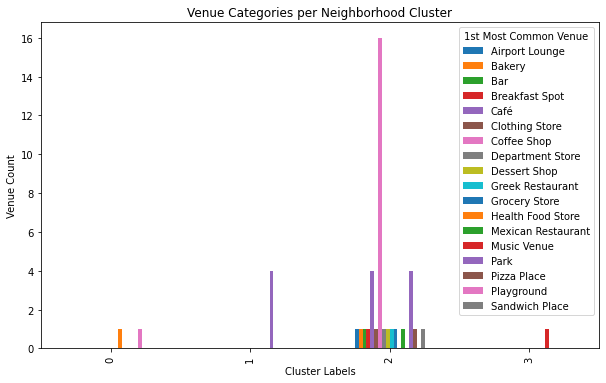

In [47]:
plot.plot.bar(figsize=(10,6), ylabel='Venue Count',title='Venue Categories per Neighborhood Cluster')

In this section, a map is created using a Folium package to visualize all 4 clusters

In [41]:
# create map
map_clusters = folium.Map(location=[tor_lat, tor_lon], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**10 for i in range(kclusters)]
colors_array = cm.viridis(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Map of Selected Toronto Neighborhood Clusters </b></h3>
             '''
map_clusters.get_root().html.add_child(folium.Element(title_html))
      
map_clusters

> We can see from the map above that most of the Neighborhoods fall into Cluster 2 followed by Cluster 1 and 0. 

## 10. Conclusion

In conclusion, we can segment the Selected Toronto Boroughs into 4 major clusters based on similarity of the venues:

Cluster 0 - Neighborhoods with Playgrounds & Health Stores

Cluster 1 - Neighborhoods with Parks

Cluster 2 - Neighborhoods with Coffee shops and Restaurants

Cluster 3 - Neighborhoods with Music Venues

We can also see from the Map of Toronto that Neighborhoods in Cluster 2 are in boroughs that are quite close together and from living in the city, seems to be busy boroughs with lots of offices. 